# MLflow + Optuna + GridSearch para Churn (Telco)

Este cuaderno demuestra cómo registrar experimentos en MLflow mientras se ajustan modelos como XGBoost, LightGBM y MLPClassifier usando GridSearchCV, RandomizedSearchCV y Optuna.

In [2]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import optuna

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# Cargar dataset Telco
url = url = 'C:/MLOPS/clase_mlops/Proyecto_1/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(url)
df = df.drop(columns=['customerID'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Churn_Yes', axis=1)
y = df['Churn_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
mlflow.set_experiment("MLflow Churn")

<Experiment: artifact_location='file:///c:/MLOPS/clase_mlops/Proyecto_1/notebooks/mlruns/946017762957733847', creation_time=1743727627825, experiment_id='946017762957733847', last_update_time=1743727627825, lifecycle_stage='active', name='MLflow Churn', tags={}>

## GridSearchCV con XGBoost

In [19]:
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=params, cv=3)
with mlflow.start_run(run_name='XGBoost GridSearch'):
    grid.fit(X_train, y_train)
    preds = grid.predict(X_test)
    acc = accuracy_score(y_test, preds)
    recall  = recall_score(y_test, preds)
    for param, val in grid.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('recall', recall)
    mlflow.sklearn.log_model(grid.best_estimator_, 'model')

c:\MLOPS\clase_mlops\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

## RandomizedSearchCV con LightGBM

In [20]:
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.2)
}

rand_search = RandomizedSearchCV(LGBMClassifier(), param_distributions=param_dist, n_iter=10, cv=3)
with mlflow.start_run(run_name='LightGBM RandomizedSearch'):
    rand_search.fit(X_train, y_train)
    preds = rand_search.predict(X_test)
    acc = accuracy_score(y_test, preds)
    recall  = recall_score(y_test, preds)
    for param, val in rand_search.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('recall', recall)
    mlflow.sklearn.log_model(rand_search.best_estimator_, 'model')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 996, number of negative: 2754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 3750, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265600 -> initscore=-1.017062
[LightGBM] [Info] Start training from score -1.017062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

2025/04/03 20:07:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Optuna con MLPClassifier

In [23]:
def objective(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (128,), (64, 32)])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 0.001, 0.1)

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=500, random_state=42, 
                              hidden_layer_sizes=hidden_layer_sizes,
                              alpha=alpha, learning_rate_init=learning_rate_init))
    ])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return recall_score(y_test, preds)

study = optuna.create_study(direction='maximize')
with mlflow.start_run(run_name='MLP Optuna'):
    study.optimize(objective, n_trials=20)
    for k, v in study.best_params.items():
        mlflow.log_param(k, v)
    mlflow.log_metric('recall', study.best_value)

[I 2025-04-03 20:21:47,330] A new study created in memory with name: no-name-2ccc1563-8a8a-4bcb-a7e1-5afc252142d6
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
c:\MLOPS\clase_mlops\.venv\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 32) which is of type tuple.
  warnings.warn(message)
[I 2025-04-03 20:21:48,189] Trial 0 finished with value: 0.5374331550802139

## Visualización y Comparación de Resultados

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns

# Función para visualizar métricas de un modelo
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"\n{nombre}: AUC = {roc_auc:.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {nombre}')
    plt.legend()
    plt.grid(True)
    plt.show()

    sns.histplot(y_proba, kde=True, bins=30)
    plt.title(f'Distribución de probabilidades - {nombre}')
    plt.xlabel('Probabilidad predicha')
    plt.grid(True)
    plt.show()


XGBoost: AUC = 0.834


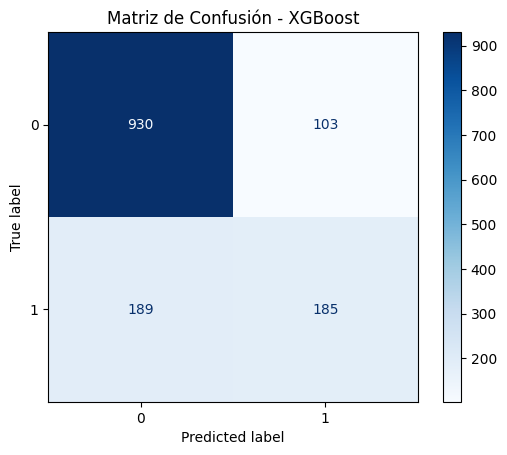

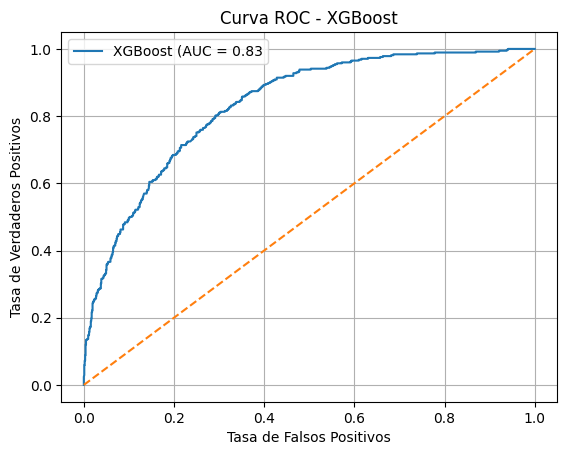

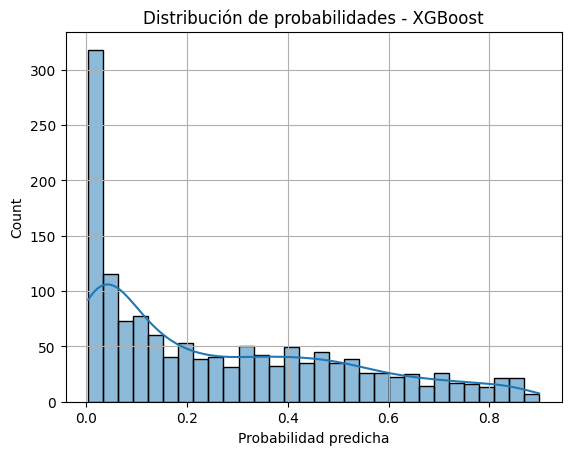


LightGBM: AUC = 0.834


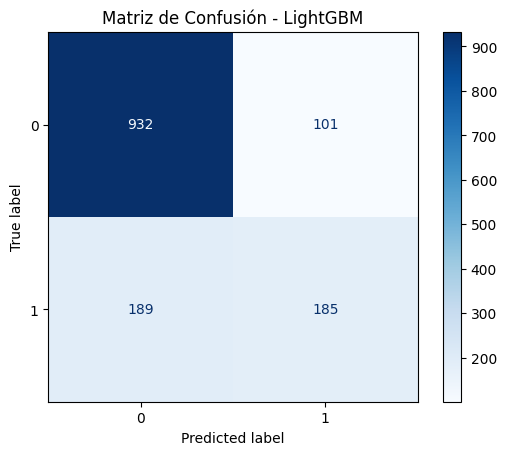

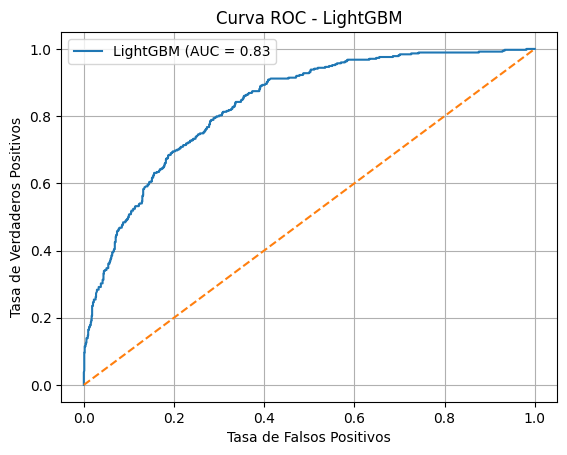

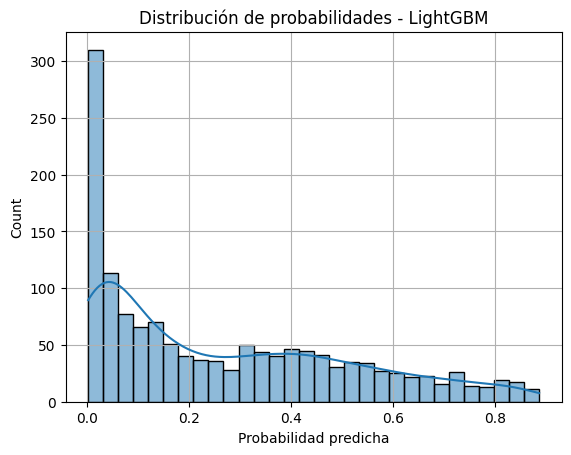


MLP Optuna: AUC = 0.749


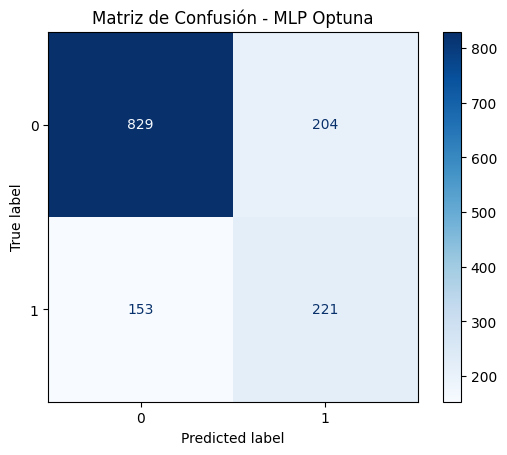

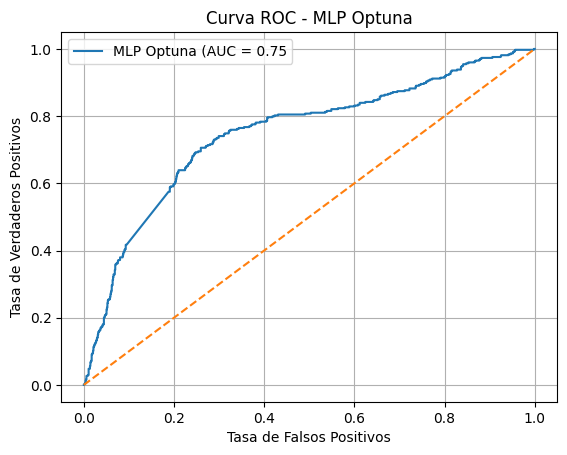

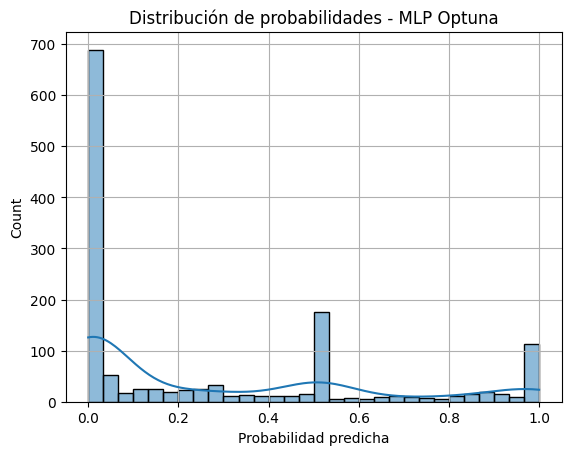

In [27]:
# Evaluación de modelos después del ajuste
evaluar_modelo('XGBoost', grid.best_estimator_, X_test, y_test)
evaluar_modelo('LightGBM', rand_search.best_estimator_, X_test, y_test)

# Reconstruir MLP final con mejores parámetros
from sklearn.pipeline import Pipeline
best_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, random_state=42, 
        hidden_layer_sizes=study.best_params['hidden_layer_sizes'],
        alpha=study.best_params['alpha'],
        learning_rate_init=study.best_params['learning_rate_init']))
])
best_mlp.fit(X_train, y_train)
evaluar_modelo('MLP Optuna', best_mlp, X_test, y_test)

In [5]:
from sklearn.svm import SVC
from scipy.stats import uniform, randint

# Definir el espacio de búsqueda de parámetros para SVM
param_dist = {
    'C': uniform(0.1, 10),              # Rango de valores para el parámetro de regularización C
    'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'gamma': ['scale', 'auto']           # Valores para gamma (sólo para kernels no lineales como 'rbf' y 'poly')
}

# Realizar la búsqueda aleatoria de parámetros
rand_search = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist, n_iter=10, cv=3)

with mlflow.start_run(run_name='SVM RandomizedSearch'):
    rand_search.fit(X_train, y_train)
    
    # Predicciones
    preds = rand_search.predict(X_test)
    y_proba = rand_search.predict_proba(X_test)[:, 1]  # Para obtener las probabilidades de clase positiva

    # Calcular métricas
    acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    
    # Registrar los mejores parámetros y métricas en MLflow
    for param, val in rand_search.best_params_.items():
        mlflow.log_param(param, val)
    mlflow.log_metric('accuracy', acc)
    mlflow.log_metric('recall', recall)
    
    # Registrar el modelo en MLflow
    mlflow.sklearn.log_model(rand_search.best_estimator_, 'svm_model')


KeyboardInterrupt: 